# Hyper-parameter scans

Here we consider how different optimization algorithms behave (for this system) and how their hyper parameters influence the resulting cluster expansion.
We use the cutoffs `[8.0, 6.5, 6.0]` and consider the following optimization algorithms

* ARDR (Automatic Relevance Determination Regression)
* RFE (Recursive Feature Elimination)
* LASSO (Least Absolute Shrinkage and Selection Operator)
* Adaptive-LASSO

From the analyis above one can conclude that around 20 to 30 non-zero ECIs are a good choice with cutoffs `[8.0, 6.5, 6.0]`.
We also note here that LASSO performs quite poorly compared to the other methods, whereas the other three methods all yield similar results.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ase.db import connect
from icet import ClusterSpace, StructureContainer
from trainstation import CrossValidationEstimator

## Preparations

We set up the cluster space and prepare the reference data.

In [2]:
# access database with reference data
db = connect('../../tutorial/reference_data.db')

# set up cluster space
primitive_structure = db.get(id=1).toatoms()
cs = ClusterSpace(
    structure=primitive_structure,
    cutoffs=[8.0, 6.5, 6.0],
    chemical_symbols=['Ag', 'Pd']
)

# compile fit data
sc = StructureContainer(cluster_space=cs)
for row in db.select():
    sc.add_structure(
        structure=row.toatoms(),
        user_tag=row.tag,
        properties={'mixing_energy': row.mixing_energy},
    )
A, y = sc.get_fit_data(key='mixing_energy')

Furthermore we define a convenience function that extracts pertinent information from a [CrossValidationEstimator object](https://trainstation.materialsmodeling.org/moduleref.html#crossvalidationestimator).

In [3]:
def get_row(cve: CrossValidationEstimator):
    row = dict()
    row['rmse_validation'] = cve.rmse_validation
    row['rmse_train'] = cve.rmse_train
    row['BIC'] = cve.model.BIC
    row['n_parameters'] = cve.n_parameters
    row['n_nonzero_parameters'] = cve.n_nonzero_parameters
    return row

## ARDR: Hyperparameter scan

ARDR has the hyper-parameter `threshold-lambda` which controls the sparsity of the solution.

In [4]:
lambda_values = [250, 500, 1000, 1400, 2000, 2500, 4500, 7500,
                 13000, 18000, 25000, 40000, 60000, 90000, 200000]
records = []
for lam in lambda_values:
    cve = CrossValidationEstimator((A, y), fit_method='ardr', threshold_lambda=lam)
    cve.validate()
    cve.train()
    row = get_row(cve)
    row['threshold_lambda'] = lam
    records.append(row)
df_ardr = pd.DataFrame(records)

## RFE: Hyperparameter scan

RFE has the hyper-parameter `n_features` which controls the sparsity of the solution.

In [5]:
nf_values = np.arange(10, len(cs), 4)
records = []
for nf in nf_values:
    cve = CrossValidationEstimator((A, y), fit_method='rfe', n_features=nf)
    cve.validate()
    cve.train()
    row = get_row(cve)
    records.append(row)
df_rfe = pd.DataFrame(records)

## LASSO: Hyperparameter scan

In [6]:
alpha_values = np.logspace(-5, -0.5, 20)
records = []
for alpha in alpha_values:
    cve = CrossValidationEstimator((A, y), max_iter=50000, fit_method='lasso', alpha=alpha)
    cve.validate()
    cve.train()
    row = get_row(cve)
    row['alpha'] = alpha
    records.append(row)
df_lasso = pd.DataFrame(records)

## Adaptive-LASSO: Hyperparameter scan

In [7]:
alpha_values = np.logspace(-5, -1.5, 20)
records = []
for alpha in alpha_values:
    cve = CrossValidationEstimator((A, y), max_iter=50000,
                                   fit_method='adaptive-lasso', alpha=alpha)
    cve.validate()
    cve.train()
    row = get_row(cve)
    row['alpha'] = alpha
    records.append(row)
df_adlasso = pd.DataFrame(records)

## Plot results

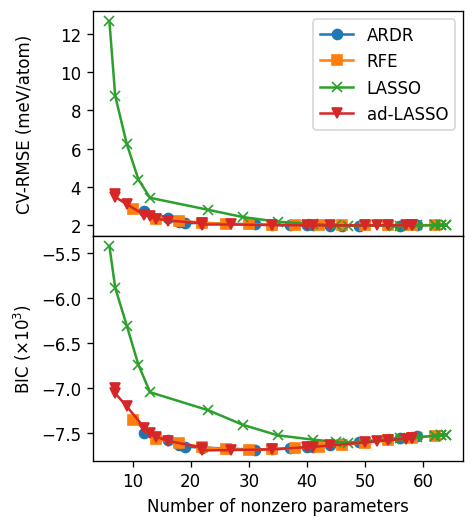

In [8]:
fig, axes = plt.subplots(
    figsize=(4, 4.5),
    dpi=120,
    sharex=True,
    nrows=2,
)

ax = axes[0]
conv = 1e3
ax.set_ylabel('CV-RMSE (meV/atom)')
ax.plot(df_ardr.n_nonzero_parameters, conv * df_ardr.rmse_validation,
        '-o', label='ARDR')
ax.plot(df_rfe.n_nonzero_parameters, conv * df_rfe.rmse_validation,
        '-s', label='RFE')
ax.plot(df_lasso.n_nonzero_parameters, conv * df_lasso.rmse_validation,
        '-x', label='LASSO')
ax.plot(df_adlasso.n_nonzero_parameters, conv * df_adlasso.rmse_validation,
        '-v', label='ad-LASSO')
ax.legend()

ax = axes[1]
conv = 1e-3
ax.set_ylabel(r'BIC ($\times 10^{3}$)')
ax.plot(df_ardr.n_nonzero_parameters, conv * df_ardr.BIC, '-o', label='ARDR')
ax.plot(df_rfe.n_nonzero_parameters, conv * df_rfe.BIC, '-s', label='RFE')
ax.plot(df_lasso.n_nonzero_parameters, conv * df_lasso.BIC, '-x', label='LASSO')
ax.plot(df_adlasso.n_nonzero_parameters, conv * df_adlasso.BIC, '-v', label='ad-LASSO')

axes[-1].set_xlabel('Number of nonzero parameters')

fig.tight_layout()
fig.subplots_adjust(hspace=0)
fig.align_ylabels(axes)